In [1]:
# CAPM-analyysi ja Portfolio-optimointi
# Capital Asset Pricing Model -laskelmat ja visualisoinnit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import warnings
warnings.filterwarnings('ignore')

# Matplotlib-asetukset
plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'white'
try:
    sns.set_style("whitegrid")
    sns.set_palette("husl")
except:
    plt.style.use('ggplot')

In [2]:
class CAPMAnalyzer:
    def __init__(self, risk_free_rate=0.02):
        self.risk_free_rate = risk_free_rate
        self.data = None
        self.returns = None
        self.market_returns = None
        
    def generate_sample_data(self, n_periods=252, n_assets=8):
        np.random.seed(42)
        
        companies = {
            'NOKIA': {'sector': 'Technology', 'beta_true': 1.2, 'volatility': 0.28},
            'FORTUM': {'sector': 'Utilities', 'beta_true': 0.8, 'volatility': 0.22},
            'NORDEA': {'sector': 'Financials', 'beta_true': 1.4, 'volatility': 0.32},
            'KONE': {'sector': 'Industrials', 'beta_true': 1.1, 'volatility': 0.25},
            'NESTE': {'sector': 'Energy', 'beta_true': 0.9, 'volatility': 0.26},
            'ORION': {'sector': 'Healthcare', 'beta_true': 0.7, 'volatility': 0.20},
            'SAMPO': {'sector': 'Insurance', 'beta_true': 1.0, 'volatility': 0.24},
            'UPM': {'sector': 'Materials', 'beta_true': 1.3, 'volatility': 0.30}
        }
        
        market_volatility = 0.20
        market_drift = 0.08
        dt = 1/252
        dates = pd.date_range(start='2022-01-01', periods=n_periods, freq='D')
        
        market_shocks = np.random.normal(0, market_volatility * np.sqrt(dt), n_periods)
        market_returns = market_drift * dt + market_shocks
        market_prices = 100 * np.exp(np.cumsum(market_returns))
        
        stock_data = {'Date': dates, 'Market': market_prices}
        
        for stock, params in companies.items():
            idiosync_shocks = np.random.normal(0, 
                np.sqrt(params['volatility']**2 - (params['beta_true'] * market_volatility)**2) * np.sqrt(dt), 
                n_periods)
            
            stock_returns = (self.risk_free_rate * dt + 
                           params['beta_true'] * (market_returns - self.risk_free_rate * dt) + 
                           idiosync_shocks)
            
            stock_prices = 100 * np.exp(np.cumsum(stock_returns))
            stock_data[stock] = stock_prices
        
        self.data = pd.DataFrame(stock_data)
        self.data.set_index('Date', inplace=True)
        self.returns = self.data.pct_change().dropna()
        self.market_returns = self.returns['Market']
        
        return self.data, companies
    
    def calculate_beta(self, stock_returns, market_returns):
        excess_stock = stock_returns - self.risk_free_rate/252
        excess_market = market_returns - self.risk_free_rate/252
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(excess_market, excess_stock)
        
        return {
            'beta': slope,
            'alpha': intercept * 252,
            'r_squared': r_value**2,
            'p_value': p_value,
            'std_error': std_err,
            'correlation': r_value
        }
    
    def calculate_capm_return(self, beta, market_return_expected=0.08):
        return self.risk_free_rate + beta * (market_return_expected - self.risk_free_rate)
    
    def calculate_sharpe_ratio(self, returns):
        excess_returns = returns - self.risk_free_rate/252
        return np.sqrt(252) * excess_returns.mean() / returns.std()
    
    def calculate_treynor_ratio(self, returns, beta):
        excess_returns = (returns.mean() * 252) - self.risk_free_rate
        return excess_returns / beta

In [3]:
# Luo CAPM-analyysityökalu
analyzer = CAPMAnalyzer(risk_free_rate=0.02)

print("📈 CAPM-ANALYYSI JA PORTFOLIO-OPTIMOINTI")
print("=" * 60)
print("Capital Asset Pricing Model -analyysi suomalaisille osakkeille\n")

# 1. GENEROI JA ANALYSOI DATA
print("📊 1. DATAN GENEROINTI JA PERUSTIEDOT")
print("-" * 50)

data, companies_info = analyzer.generate_sample_data(n_periods=252*2)

print("Analyysissa mukana olevat osakkeet:")
for stock, info in companies_info.items():
    print(f"  {stock:8} | {info['sector']:12} | Beta: {info['beta_true']:.1f} | Vol: {info['volatility']:.1%}")

print(f"\nDataperioodi: {data.index[0].strftime('%Y-%m-%d')} - {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Havaintoja: {len(data)} päivää")
print(f"Riskitön korko: {analyzer.risk_free_rate:.1%}")

print(f"\nPERUSTILASTOT (vuositettu):")
print(f"{'Osake':<8} {'Keskituotto':<12} {'Volatiliteetti':<14} {'Sharpe':<8}")
print("-" * 45)

for stock in analyzer.returns.columns:
    avg_return = analyzer.returns[stock].mean() * 252
    volatility = analyzer.returns[stock].std() * np.sqrt(252)
    sharpe = analyzer.calculate_sharpe_ratio(analyzer.returns[stock])
    print(f"{stock:<8} {avg_return:>10.1%} {volatility:>12.1%} {sharpe:>10.2f}")

# 2. BETA-ANALYYSI
print(f"\n📊 2. BETA-KERROINTEN ANALYYSI")
print("-" * 50)

beta_results = {}
stock_list = [col for col in analyzer.returns.columns if col != 'Market']

for stock in stock_list:
    beta_stats = analyzer.calculate_beta(analyzer.returns[stock], analyzer.market_returns)
    beta_results[stock] = beta_stats
    
    expected_return = analyzer.calculate_capm_return(beta_stats['beta'])
    treynor = analyzer.calculate_treynor_ratio(analyzer.returns[stock], beta_stats['beta'])
    
    print(f"\n{stock}:")
    print(f"  Beta: {beta_stats['beta']:.3f} (±{beta_stats['std_error']:.3f})")
    print(f"  Alpha: {beta_stats['alpha']:.2%} p.a.")
    print(f"  R²: {beta_stats['r_squared']:.3f}")
    print(f"  CAPM odotettu tuotto: {expected_return:.2%}")
    print(f"  Toteutunut tuotto: {analyzer.returns[stock].mean() * 252:.2%}")
    print(f"  Treynor-suhde: {treynor:.3f}")

📈 CAPM-ANALYYSI JA PORTFOLIO-OPTIMOINTI
Capital Asset Pricing Model -analyysi suomalaisille osakkeille

📊 1. DATAN GENEROINTI JA PERUSTIEDOT
--------------------------------------------------
Analyysissa mukana olevat osakkeet:
  NOKIA    | Technology   | Beta: 1.2 | Vol: 28.0%
  FORTUM   | Utilities    | Beta: 0.8 | Vol: 22.0%
  NORDEA   | Financials   | Beta: 1.4 | Vol: 32.0%
  KONE     | Industrials  | Beta: 1.1 | Vol: 25.0%
  NESTE    | Energy       | Beta: 0.9 | Vol: 26.0%
  ORION    | Healthcare   | Beta: 0.7 | Vol: 20.0%
  SAMPO    | Insurance    | Beta: 1.0 | Vol: 24.0%
  UPM      | Materials    | Beta: 1.3 | Vol: 30.0%

Dataperioodi: 2022-01-01 - 2023-05-19
Havaintoja: 504 päivää
Riskitön korko: 2.0%

PERUSTILASTOT (vuositettu):
Osake    Keskituotto  Volatiliteetti Sharpe  
---------------------------------------------
Market        13.0%        19.7%       0.56
NOKIA         25.5%        28.2%       0.83
FORTUM        35.5%        22.7%       1.47
NORDEA        24.8%        3

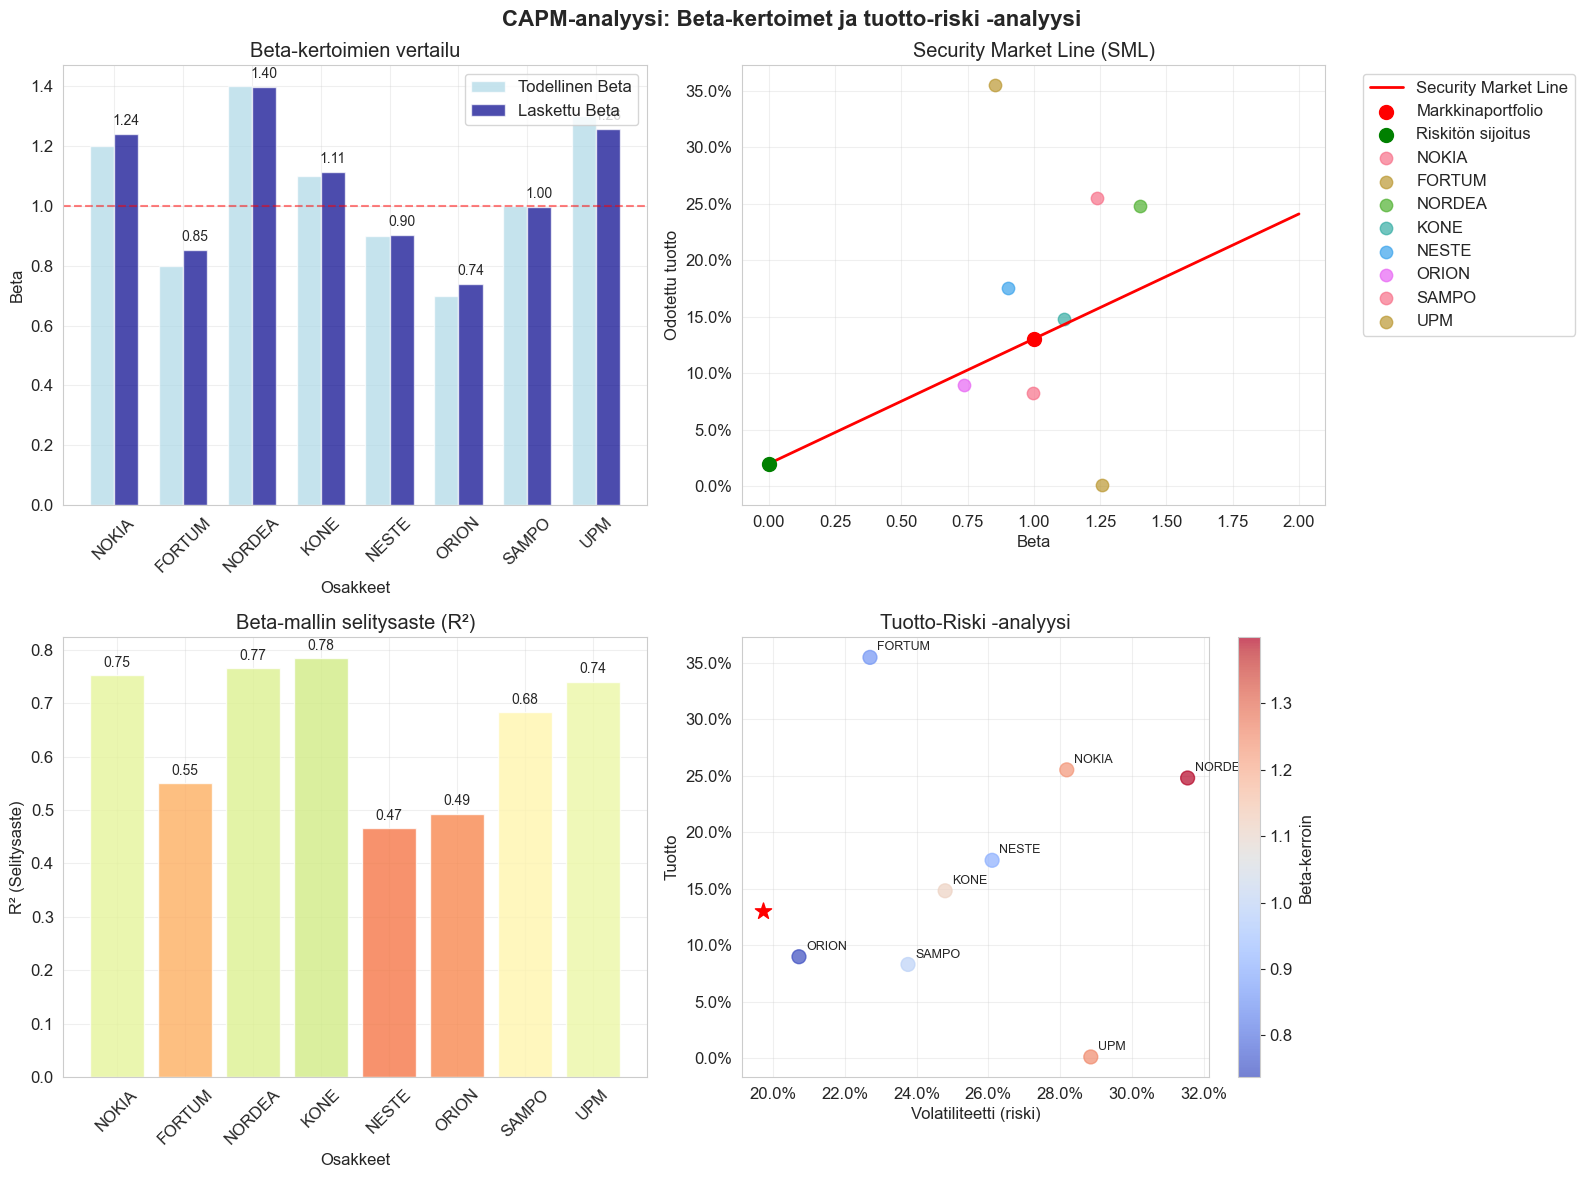


🏢 3. SEKTORANALYYSI
--------------------------------------------------
SEKTOREIDEN KESKIARVOT:
Sektori         Beta     Tuotto     Vol.     Sharpe  
-------------------------------------------------------
Technology        1.24    25.5%  28.2%     0.83
Utilities         0.85    35.5%  22.7%     1.47
Financials        1.40    24.8%  31.5%     0.72
Industrials       1.11    14.8%  24.8%     0.52
Energy            0.90    17.5%  26.1%     0.59
Healthcare        0.74     9.0%  20.7%     0.34
Insurance         1.00     8.3%  23.8%     0.27
Materials         1.26     0.1%  28.8%    -0.07


In [4]:
# VISUALISOINTI 1: Beta-analyysi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CAPM-analyysi: Beta-kertoimet ja tuotto-riski -analyysi', fontsize=16, fontweight='bold')

# 1. Beta-vertailu
ax1 = axes[0, 0]
stocks = list(beta_results.keys())
betas = [beta_results[stock]['beta'] for stock in stocks]
true_betas = [companies_info[stock]['beta_true'] for stock in stocks]

x_pos = np.arange(len(stocks))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, true_betas, width, label='Todellinen Beta', alpha=0.7, color='lightblue')
bars2 = ax1.bar(x_pos + width/2, betas, width, label='Laskettu Beta', alpha=0.7, color='darkblue')

ax1.set_xlabel('Osakkeet')
ax1.set_ylabel('Beta')
ax1.set_title('Beta-kertoimien vertailu')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(stocks, rotation=45)
ax1.legend()
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars2, betas):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# 2. Security Market Line
ax2 = axes[0, 1]
market_return = analyzer.market_returns.mean() * 252
betas_range = np.linspace(0, 2, 100)
sml_returns = [analyzer.calculate_capm_return(b, market_return) for b in betas_range]

ax2.plot(betas_range, sml_returns, 'r-', linewidth=2, label='Security Market Line')
ax2.scatter([1], [market_return], color='red', s=100, label='Markkinaportfolio', zorder=5)
ax2.scatter([0], [analyzer.risk_free_rate], color='green', s=100, label='Riskitön sijoitus', zorder=5)

for stock in stocks:
    beta = beta_results[stock]['beta']
    actual_return = analyzer.returns[stock].mean() * 252
    ax2.scatter([beta], [actual_return], s=80, alpha=0.7, label=stock)

ax2.set_xlabel('Beta')
ax2.set_ylabel('Odotettu tuotto')
ax2.set_title('Security Market Line (SML)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

# 3. R²-analyysi
ax3 = axes[1, 0]
r_squareds = [beta_results[stock]['r_squared'] for stock in stocks]
colors = plt.cm.RdYlGn([r**2 for r in r_squareds])

bars = ax3.bar(stocks, r_squareds, color=colors, alpha=0.8)
ax3.set_xlabel('Osakkeet')
ax3.set_ylabel('R² (Selitysaste)')
ax3.set_title('Beta-mallin selitysaste (R²)')
ax3.set_xticklabels(stocks, rotation=45)
ax3.grid(True, alpha=0.3)

for bar, value in zip(bars, r_squareds):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# 4. Tuotto vs. Riski
ax4 = axes[1, 1]
returns_annual = [analyzer.returns[stock].mean() * 252 for stock in stocks]
volatilities = [analyzer.returns[stock].std() * np.sqrt(252) for stock in stocks]

scatter = ax4.scatter(volatilities, returns_annual, 
                     c=[beta_results[stock]['beta'] for stock in stocks],
                     s=100, alpha=0.7, cmap='coolwarm')

for i, stock in enumerate(stocks):
    ax4.annotate(stock, (volatilities[i], returns_annual[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

market_vol = analyzer.market_returns.std() * np.sqrt(252)
market_ret = analyzer.market_returns.mean() * 252
ax4.scatter([market_vol], [market_ret], color='red', s=150, marker='*', 
           label='Markkinaportfolio', zorder=5)

ax4.set_xlabel('Volatiliteetti (riski)')
ax4.set_ylabel('Tuotto')
ax4.set_title('Tuotto-Riski -analyysi')
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax4.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Beta-kerroin')

plt.tight_layout()
plt.show()

# 3. SEKTORANALYYSI
print(f"\n🏢 3. SEKTORANALYYSI")
print("-" * 50)

sector_analysis = {}
for stock, info in companies_info.items():
    sector = info['sector']
    if sector not in sector_analysis:
        sector_analysis[sector] = {
            'stocks': [],
            'betas': [],
            'returns': [],
            'volatilities': [],
            'sharpes': []
        }
    
    sector_analysis[sector]['stocks'].append(stock)
    sector_analysis[sector]['betas'].append(beta_results[stock]['beta'])
    sector_analysis[sector]['returns'].append(analyzer.returns[stock].mean() * 252)
    sector_analysis[sector]['volatilities'].append(analyzer.returns[stock].std() * np.sqrt(252))
    sector_analysis[sector]['sharpes'].append(analyzer.calculate_sharpe_ratio(analyzer.returns[stock]))

print("SEKTOREIDEN KESKIARVOT:")
print(f"{'Sektori':<15} {'Beta':<8} {'Tuotto':<10} {'Vol.':<8} {'Sharpe':<8}")
print("-" * 55)

for sector, data in sector_analysis.items():
    avg_beta = np.mean(data['betas'])
    avg_return = np.mean(data['returns'])
    avg_vol = np.mean(data['volatilities'])
    avg_sharpe = np.mean(data['sharpes'])
    
    print(f"{sector:<15} {avg_beta:>6.2f} {avg_return:>8.1%} {avg_vol:>6.1%} {avg_sharpe:>8.2f}")


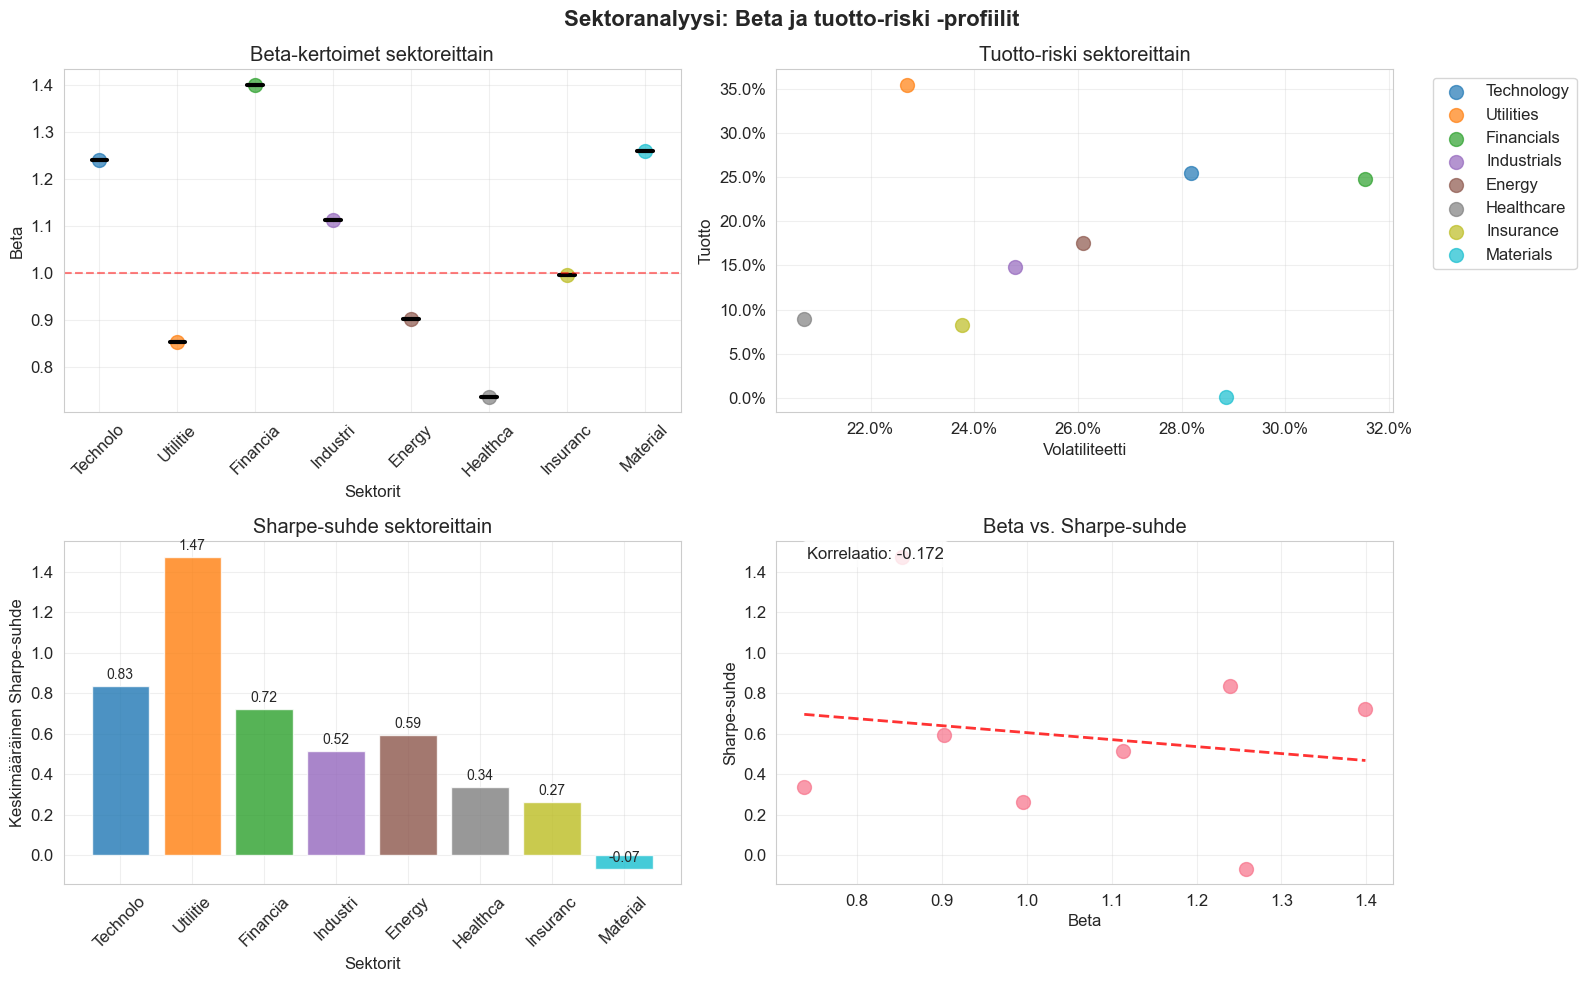

In [5]:
# VISUALISOINTI 2: Sektoranalyysi
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sektoranalyysi: Beta ja tuotto-riski -profiilit', fontsize=16, fontweight='bold')

sectors = list(sector_analysis.keys())
colors_sector = plt.cm.tab10(np.linspace(0, 1, len(sectors)))

# 1. Beta sektoreittain
ax1 = axes[0, 0]
for i, (sector, data) in enumerate(sector_analysis.items()):
    ax1.scatter([i] * len(data['betas']), data['betas'], 
               color=colors_sector[i], alpha=0.7, s=100, label=sector)
    ax1.plot([i-0.1, i+0.1], [np.mean(data['betas'])]*2, 
             color='black', linewidth=3)

ax1.set_xlabel('Sektorit')
ax1.set_ylabel('Beta')
ax1.set_title('Beta-kertoimet sektoreittain')
ax1.set_xticks(range(len(sectors)))
ax1.set_xticklabels([s[:8] for s in sectors], rotation=45)
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

# 2. Tuotto vs. riski sektoreittain
ax2 = axes[0, 1]
for i, (sector, data) in enumerate(sector_analysis.items()):
    ax2.scatter(data['volatilities'], data['returns'], 
               color=colors_sector[i], alpha=0.7, s=100, label=sector)

ax2.set_xlabel('Volatiliteetti')
ax2.set_ylabel('Tuotto')
ax2.set_title('Tuotto-riski sektoreittain')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Sharpe-suhde sektoreittain
ax3 = axes[1, 0]
sector_sharpes = [np.mean(data['sharpes']) for data in sector_analysis.values()]
bars = ax3.bar(range(len(sectors)), sector_sharpes, color=colors_sector, alpha=0.8)
ax3.set_xlabel('Sektorit')
ax3.set_ylabel('Keskimääräinen Sharpe-suhde')
ax3.set_title('Sharpe-suhde sektoreittain')
ax3.set_xticks(range(len(sectors)))
ax3.set_xticklabels([s[:8] for s in sectors], rotation=45)
ax3.grid(True, alpha=0.3)

for bar, value in zip(bars, sector_sharpes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# 4. Beta vs. Sharpe korrelatio
ax4 = axes[1, 1]
all_betas = []
all_sharpes = []

for sector, data in sector_analysis.items():
    all_betas.extend(data['betas'])
    all_sharpes.extend(data['sharpes'])

ax4.scatter(all_betas, all_sharpes, alpha=0.7, s=100)
z = np.polyfit(all_betas, all_sharpes, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(all_betas), max(all_betas), 100)
ax4.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

correlation = np.corrcoef(all_betas, all_sharpes)[0, 1]
ax4.text(0.05, 0.95, f'Korrelaatio: {correlation:.3f}', 
         transform=ax4.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4.set_xlabel('Beta')
ax4.set_ylabel('Sharpe-suhde')
ax4.set_title('Beta vs. Sharpe-suhde')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# 4. YHTEENVETO
print(f"\n📋 4. YHTEENVETO JA SUOSITUKSET")
print("=" * 60)

best_sharpe_stock = max(stock_list, key=lambda x: analyzer.calculate_sharpe_ratio(analyzer.returns[x]))
worst_sharpe_stock = min(stock_list, key=lambda x: analyzer.calculate_sharpe_ratio(analyzer.returns[x]))
best_alpha_stock = max(stock_list, key=lambda x: beta_results[x]['alpha'])
lowest_beta_stock = min(stock_list, key=lambda x: beta_results[x]['beta'])
highest_beta_stock = max(stock_list, key=lambda x: beta_results[x]['beta'])

print("KESKEISTEN LÖYDÖSTEN YHTEENVETO:")
print(f"• Paras Sharpe-suhde: {best_sharpe_stock} ({analyzer.calculate_sharpe_ratio(analyzer.returns[best_sharpe_stock]):.3f})")
print(f"• Huonoin Sharpe-suhde: {worst_sharpe_stock} ({analyzer.calculate_sharpe_ratio(analyzer.returns[worst_sharpe_stock]):.3f})")
print(f"• Paras alpha: {best_alpha_stock} ({beta_results[best_alpha_stock]['alpha']:.2%})")
print(f"• Matalin beta: {lowest_beta_stock} ({beta_results[lowest_beta_stock]['beta']:.3f})")
print(f"• Korkein beta: {highest_beta_stock} ({beta_results[highest_beta_stock]['beta']:.3f})")

print(f"\nSIJOITUSSTRATEGIAN SUOSITUKSET:")
high_beta_stocks = [stock for stock in stock_list if beta_results[stock]['beta'] > 1.2]
low_beta_stocks = [stock for stock in stock_list if beta_results[stock]['beta'] < 0.8]

print(f"• Korkean betan osakkeet ({', '.join(high_beta_stocks)}): Sopivat nouseville markkinoille")
print(f"• Matalan betan osakkeet ({', '.join(low_beta_stocks)}): Sopivat laskeville markkinoille")
print("• Hajautus eri sektoreihin vähentää riskiä merkittävästi")

print(f"\nMETODOLOGIAN VAHVUUDET:")
print("• CAPM tarjoaa systemaattisen tavan arvioida riskiä ja tuottoa")
print("• Beta-kertoimet auttavat ymmärtämään markkinaherkkyyttä")
print("• Sektoranalyysi paljastaa toimialakohtaisia eroja")

print("\n" + "="*60)
print("💡 TEKNINEN TOTEUTUS PORTFOLIOON:")
print("• Jupyter Notebook (.ipynb) GitLabiin")
print("• Interaktiiviset widgetit parametrien säätöön")
print("• Real-time data API-integraatio")
print("• Web-sovellus Streamlit/Dash -kirjastoilla")
print("="*60)

# Tallenna tulokset
results_df = pd.DataFrame({
    'Osake': stock_list,
    'Beta': [beta_results[stock]['beta'] for stock in stock_list],
    'Alpha_%': [beta_results[stock]['alpha']*100 for stock in stock_list],
    'R_squared': [beta_results[stock]['r_squared'] for stock in stock_list],
    'Tuotto_%': [analyzer.returns[stock].mean() * 252 * 100 for stock in stock_list],
    'Volatiliteetti_%': [analyzer.returns[stock].std() * np.sqrt(252) * 100 for stock in stock_list],
    'Sharpe': [analyzer.calculate_sharpe_ratio(analyzer.returns[stock]) for stock in stock_list],
    'Treynor': [analyzer.calculate_treynor_ratio(analyzer.returns[stock], beta_results[stock]['beta']) for stock in stock_list],
    'Sektori': [companies_info[stock]['sector'] for stock in stock_list]
})

print(f"\nDATA EXPORT - CAPM ANALYYSIN TULOKSET:")
print(results_df.round(3).to_string(index=False))

print(f"\n🎯 ANALYYSI VALMIS!")


📋 4. YHTEENVETO JA SUOSITUKSET
KESKEISTEN LÖYDÖSTEN YHTEENVETO:
• Paras Sharpe-suhde: FORTUM (1.474)
• Huonoin Sharpe-suhde: UPM (-0.065)
• Paras alpha: FORTUM (24.03%)
• Matalin beta: ORION (0.738)
• Korkein beta: NORDEA (1.399)

SIJOITUSSTRATEGIAN SUOSITUKSET:
• Korkean betan osakkeet (NOKIA, NORDEA, UPM): Sopivat nouseville markkinoille
• Matalan betan osakkeet (ORION): Sopivat laskeville markkinoille
• Hajautus eri sektoreihin vähentää riskiä merkittävästi

METODOLOGIAN VAHVUUDET:
• CAPM tarjoaa systemaattisen tavan arvioida riskiä ja tuottoa
• Beta-kertoimet auttavat ymmärtämään markkinaherkkyyttä
• Sektoranalyysi paljastaa toimialakohtaisia eroja

💡 TEKNINEN TOTEUTUS PORTFOLIOON:
• Jupyter Notebook (.ipynb) GitLabiin
• Interaktiiviset widgetit parametrien säätöön
• Real-time data API-integraatio
• Web-sovellus Streamlit/Dash -kirjastoilla

DATA EXPORT - CAPM ANALYYSIN TULOKSET:
 Osake  Beta  Alpha_%  R_squared  Tuotto_%  Volatiliteetti_%  Sharpe  Treynor     Sektori
 NOKIA 1.239